In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
labels = ['Abnormal(Covid)','Normal']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/chest_xray_dataset3200/train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1130/1130 [00:26<00:00, 42.95it/s] 


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [ ]:
X_train.shape

(2880, 224, 224, 3)

In [ ]:
X_test.shape

(320, 224, 224, 3)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import keras.backend as k
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:
k.clear_session()
def inception_module(x, f1, f2, f3, f4):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3, conv5, conv7])
		return x

In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [ ]:
#OURmODELv6
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [ ]:
# Create model.
inputs = img_input
model =  keras.Model(inputs, x, name='DFUEffectiveNetV3')
model.summary()

Model: "DFUEffectiveNetV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  192        ['conv2d[0][0]']                 
 alization)                     )                                                 

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics= 'accuracy')

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("COV_SPNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.05, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 162.6714 - accuracy: 0.8385
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to COV_SPNet.h5
86/86 [==============================] - 71s 591ms/step - loss: 162.6714 - accuracy: 0.8385 - val_loss: 1.5462 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9605
Epoch 2: val_accuracy improved from 0.68750 to 0.93056, saving model to COV_SPNet.h5
86/86 [==============================] - 42s 485ms/step - loss: 0.1351 - accuracy: 0.9605 - val_loss: 0.2355 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9719
Epoch 3: val_accuracy improved from 0.93056 to 0.93750, saving model to COV_SPNet.h5
86/86 [==============================] - 41s 472ms/step - loss: 0.1104 - accuracy: 0.9719 - val_loss: 0.1702 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/50
86/86 [=========

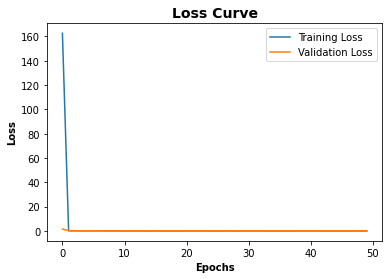

In [ ]:
#plot the loss curve
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.ylabel('Loss',fontweight='bold')
plt.title('Loss Curve',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
plt.savefig('Covid_SPNet_LossCurve',dpi=400)
plt.legend()

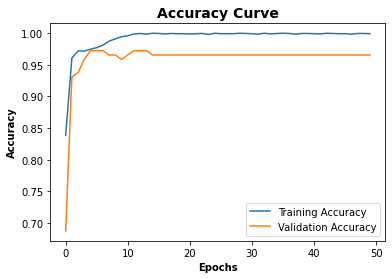

In [ ]:
#plot the accuracy curve
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Accuracy Curve',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
plt.savefig('Covid_SPNet_AccCurve',dpi=400)
plt.legend()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 1s 128ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       210
           1       0.97      0.99      0.98       110

    accuracy                           0.99       320
   macro avg       0.98      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



In [ ]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


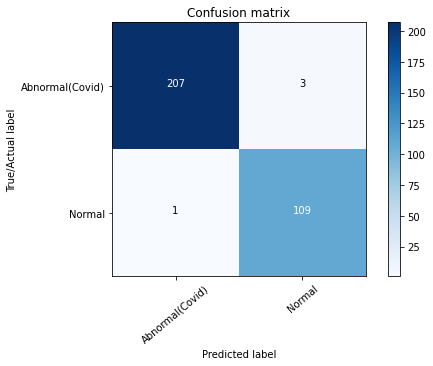

In [ ]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True/Actual label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('Covid_SPNet',dpi=400)

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [ ]:
print('TP = %.5f'%TP, 'TN = %.5f'%TN, 'FP = %.5f'%FP, 'FN = %.5f'%FN)

TP = 109.00000 TN = 207.00000 FP = 3.00000 FN = 1.00000


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.5f' % accuracy_score(y_test_new, pred), 'Precision: %.5f' % precision_score(y_test_new, pred),' Recall: %.5f' % recall_score(y_test_new, pred), 
      'F1 Score: %.5f' % f1_score(y_test_new, pred), 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.98750 Precision: 0.97321  Recall: 0.99091 F1 Score: 0.98198 AUC Score: 0.98831


In [ ]:
recall=TP/float(TP+FN)
print(recall)
print(recall_score(y_test_new, pred))

0.990909090909091
0.990909090909091


In [ ]:
precision=TP/float(TP+FP)
print(precision)

print(precision_score(y_test_new, pred))

0.9732142857142857
0.9732142857142857


In [ ]:
print((2*precision*recall)/(recall+precision))
print(f1_score(y_test_new, pred))

0.9819819819819819
0.9819819819819819


In [ ]:
specificity=TN/float(TN+FP)
print(specificity)

0.9857142857142858


In [ ]:
print(TP/float(TP+FN))
print(recall_score(y_test_new, pred))

0.990909090909091
0.990909090909091


In [ ]:
print(roc_auc_score(y_test_new, pred))

0.9883116883116885


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_new, pred)

0.0125

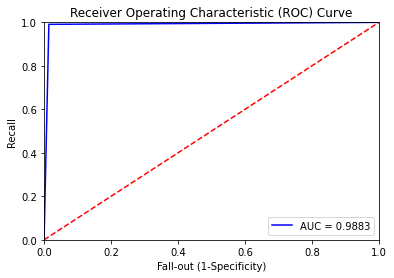

In [ ]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.4f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.savefig('Covid_SPNet_ROCCurve',dpi=400)
plt.show()


In [ ]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))
print('Validation acc: {0:0.2f}%'.format(np.round((history.history['val_accuracy'][-1])*100, 2)))

Accuracy: 98.75%
Precision: 97.32%
Recall or Sensitivity: 99.09%
Specificity: 98.57%
F1-score: 98.20%
AUC-score: 98.83%
Train acc: 99.89%
Validation acc: 96.53%


In [ ]:
#need to update with data augmentation

test_image_generator = ImageDataGenerator(
  rescale = 1.0/255)

#class_mode = 'sparse')
test_iterator = test_image_generator.flow_from_directory('/content/drive/MyDrive/chest_xray_dataset/check',
target_size = (224, 224),
batch_size = 32,
color_mode = 'rgb')
#class_mode = 'sparse')

Found 10 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

In [ ]:
from scipy import interp
from itertools import cycle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


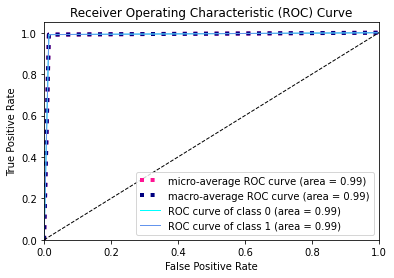

In [ ]:
# Plot linewidth.
lw = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_new, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('CXRay_SPNetROC',dpi=400)
plt.show()